In [18]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
from random import random, seed

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import sklearn.linear_model as skl

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import resample

from sklearn.preprocessing import PolynomialFeatures


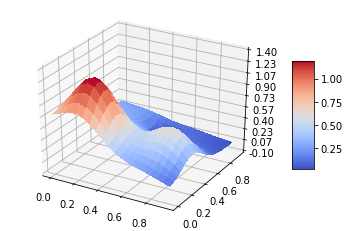

In [2]:
# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [3]:
def CreateDesignMatrix_X(x, y, n):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
        
    N = len(x)
    l = int((n+1)*(n+2)/2)
    X = np.ones((N,l))
        
    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = x**(i-k) * y**k
    return X

In [4]:
n_x = 200   # number of points

# sort the random values, else your fit will go crazy
#x = np.sort((np.random.uniform(0, 1, n_x)))
#y = np.sort(np.random.uniform(0, 1, n_x))

x = np.linspace(0, 1, n_x)
y = np.linspace(0, 1, n_x)

# use the meshgrid functionality, very useful
x, y = np.meshgrid(x,y)
z = FrankeFunction(x,y)

#Transform from matrices to vectors
x_1 = np.ravel(x)
y_1 = np.ravel(y)
n = int(len(x_1))
z_true = np.ravel(z)
z_1 = np.ravel(z) + np.random.normal(size=n) * 1 #np.random.random(n) * 1

In [5]:
m = 5        # degree of polynomial
# finally create the design matrix
X = CreateDesignMatrix_X(x_1, y_1, n=m)

z_1 is the function that gives the data, X is the design matrix

Then inverse the matrix and find β, and perform the linear regression (where ztilde is the model):

In [6]:
beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_1)
ztilde = X @ beta

# For the true function (without the noise)
beta_t = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_true)
ztilde_t = X @ beta_t

def MSE(z_data, z_model):
    n = np.size(z_model)
    return np.sum((z_data-z_model)**2)/n
print(MSE(z_true, ztilde))

def R2(z_data, z_model):
    return 1 - np.sum((z_data - z_model) ** 2) / np.sum((z_data - np.mean(z_model)) ** 2)
print(R2(z_true, ztilde))

0.002432112221155384
0.9705090167961099


In [7]:
X_train, X_test, z_train, z_test, z_true_train, z_true_test = train_test_split(X, z_1, z_true, test_size=0.2)

# Get the new model from the training data
beta2 = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)
ztilde1 = X_train @ beta2

# And the predictions for the test data
zpredict = X_test @ beta2

print("Training MSE: %0.4f" % MSE(z_train, ztilde1))
print("Test MSE: %0.4f" % MSE(z_test, zpredict))
print("True MSE: %0.4f" % MSE(z_true_test, zpredict))

print("Training R2: %0.4f" % R2(z_train, ztilde1))
print("Test R2: %0.4f" % R2(z_test, zpredict))
print("True R2: %0.4f" % R2(z_true_test, zpredict))

Training MSE: 1.0099
Test MSE: 1.0042
True MSE: 0.0027
Training R2: 0.0776
Test R2: 0.0680
True R2: 0.9678


In [ ]:
maxdegree = 20
true_mse = np.zeros(maxdegree)
train_mse = np.zeros(maxdegree)
polynomial = np.zeros(maxdegree)

for degree in range(maxdegree):
    X = CreateDesignMatrix_X(x_1, y_1, n=degree)

    X_train, X_test, z_train, z_test, z_true_train, z_true_test = train_test_split(X, z_1, z_true, test_size=0.2)
    beta2 = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)
    ztilde1 = X_train @ beta2
    zpredict = X_test @ beta2
    polynomial[degree] = degree
    true_mse[degree] = MSE(z_true_test, zpredict)
    train_mse[degree] = MSE(z_train, ztilde1)

#print(polynomial)    
#print(true_mse)
print(train_mse)

plt.plot(polynomial, np.log10(true_mse), label='true test error')
plt.plot(polynomial, np.log10(train_mse), label='training error')
plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.legend()
plt.show()

### First have a look which polynomial degree fits the data best

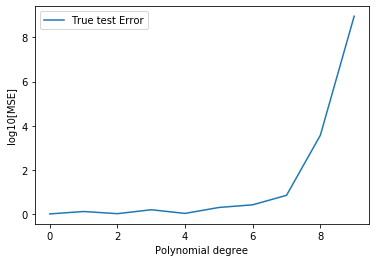

[0.         0.10889756 0.01113262 0.1888104  0.02256656 0.29178512
 0.41322206 0.8423823  3.56436835 8.95950698]


In [72]:
maxdegree = 10

testerror = np.zeros(maxdegree)
true_testerror = np.zeros(maxdegree)
trainingerror = np.zeros(maxdegree)
polynomial = np.zeros(maxdegree)

trials = 10

for polydegree in range(1, maxdegree):
    polynomial[polydegree] = polydegree
    for degree in range(polydegree):
        DM = CreateDesignMatrix_X(x_1, y_1, n=degree)

    testerror[polydegree] = 0.0
    true_testerror[polydegree] = 0.0
    trainingerror[polydegree] = 0.0
    for samples in range(trials):
        DM_train, DM_test, z_1_train, z_1_test, ztrue_train, ztrue_test = train_test_split(DM, z_1, z_true, test_size=0.2, shuffle=False)

        model = skl.LinearRegression(fit_intercept=True).fit(DM_train, z_1_train)
        ztilde = model.predict(DM_train)
        zpred = model.predict(DM_test)
        #testerror[polydegree] += mean_squared_error(z_1_test, zpred)
        true_testerror[polydegree] += mean_squared_error(ztrue_test, zpred)
        trainingerror[polydegree] += mean_squared_error(z_1_train, ztilde) 

    #testerror[polydegree] /= trials
    true_testerror[polydegree] /= trials
    trainingerror[polydegree] /= trials
    #print("Degree of polynomial: %3d"% polynomial[polydegree])
    #print("Mean squared error on training data: %.8f" % trainingerror[polydegree])
    #print("Mean squared error on test data: %.8f" % testerror[polydegree])

#plt.plot(polynomial, trainingerror, label='Training Error')
#plt.plot(polynomial, testerror, label='Test Error')
plt.plot(polynomial, true_testerror, label='True test Error')
plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.legend()
plt.show()

print(true_testerror)

It looks like a polynomial of 4 or 5 gives the lowest MSE score. 

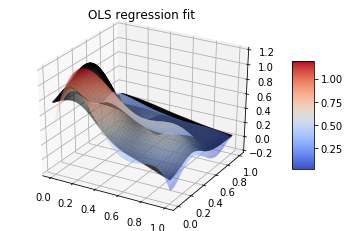

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_zlim3d(-0.2, 1.2)

#"""
ax1.scatter(x, y, z, 
           alpha=0.5, 
           s=0.1, 
           color='black'
           )
"""
ax1.scatter(x, y, z_1.reshape(x.shape), 
           alpha=0.5, 
           s=0.1, 
           color='black'
           )
"""
ax1.plot_surface(x, y, ztilde.reshape(x.shape), 
                alpha=0.5, 
                cmap=cm.coolwarm,
                )
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title(f'OLS regression fit')
plt.show()

Find the confidence intervals of the parameters β by computing their variances: 
?????

In [8]:
np.var(beta)

724.9680453912396

Next we evaluate the Mean Squared error (MSE) and the R2 score function for the model (ztilde). We evaluate it with the real FrankeFunction, the one without the noise. 

0.0024684920364307665


The MSE is ideally zero, since the smaller the value the better the fit. Here we observe an MSE of 0.09, which is pretty low, therefore indicating a good fit of the model.

0.9700773028637507


The R2 score gives the coefficient of determination, which indicates how well the model predicts future samples. The best score would be 1.0. Given that the model has a score of 0.5 , this indicates that the model would explain 50% of the future samples correct, which is quite low (not sure if we can say this though).

# Part b) Resampling techniques, adding more complexity

First split the dataset in training data and test data

In [11]:
X_train, X_test, z_train, z_test, z_true_train, z_true_test = train_test_split(X, z_1, z_true, test_size=0.2)

# Get the new model from the training data
beta2 = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)
ztilde1 = X_train @ beta2

# And the predictions for the test data
zpredict = X_test @ beta2

In [191]:
print("Training MSE: %0.4f" % MSE(z_train, ztilde1))
print("Test MSE: %0.4f" % MSE(z_test, zpredict))
print("True MSE: %0.4f" % MSE(z_true_test, zpredict))

print("Training R2: %0.4f" % R2(z_train, ztilde1))
print("Test R2: %0.4f" % R2(z_test, zpredict))
print("True R2: %0.4f" % R2(z_true_test, zpredict))

Training MSE: 1.0046
Test MSE: 1.0015
True MSE: 0.0027
Training R2: 0.0752
Test R2: 0.0719
True R2: 0.9670


The big difference between the R2 score for the test and true data are not weird, only the r2 score for the true data is interesting here. Because of the noise the R2 score for the test data is not very relevant. The training MSE can be below 1 but should be around one because your noise is * 1. The test MSE however should be 1 or slightly above, and it is kind of weird that it is smaller than 1 here, but it could be due to the small test size we are using. (when we use 1000 datapoints instead of 100 the mse indeed goes above 1

K-fold cross validation

In [180]:
# Initialize a KFold instance
k = 10
kfold = KFold(n_splits = k, shuffle=True)

In [83]:
def cross_validation(x, y, k):
    n = len(x)
    
    indexes = np.arange(y.shape[0])
    np.random.shuffle(indexes)
    x = x[indexes]
    y = y[indexes]
    
    r2_test = []
    mse_test = []
    for i in range(k):
        x_train = np.concatenate((x[:int(i*n/k)], x[int((i + 1)*n/k): ]), axis = 0)
        x_test = x[int(i*n/k):int((i + 1)*n/k)]
        y_train = np.concatenate((y[:int(i*n/k)], y[int((i + 1)*n/k): ]), axis = 0)
        y_test = y[int(i*n/k):int((i + 1)*n/k)]

        beta = np.linalg.inv(x_train.T.dot(x_train)).dot(x_train.T).dot(y_train)
        ytilde = x_train @ beta
        ypredict = x_test @ beta
        
        mse_test.append(MSE(y_test, ypredict))
        r2_test.append(R2(y_test, ypredict))
    
    r2_test = np.array(r2_test)
    mse_test = np.array(mse_test)
    print("R2-Score: %0.3f (+/- %0.3f)" % (r2_test.mean(), r2_test.std() * 2))
    print("MSE-Score: %0.5f (+/- %0.5f)" % (mse_test.mean(), mse_test.std() * 2))
        
    return r2_test, mse_test

In [182]:
r, m = cross_validation(X, z_1, k)

R2-Score: 0.072 (+/- 0.026)
MSE-Score: 0.99881 (+/- 0.03958)


In [170]:
print(r)

[0.2542239  0.23640773 0.23990536 0.22787225 0.27685791 0.25010122
 0.21455818 0.26582908 0.23267446 0.28594524]


Perform the sk-learn cross-validation to estimate R2 and MSE

In [18]:
linreg = skl.LinearRegression()
linreg.fit(X_train, z_train)

ztilde2 = linreg.predict(X_test)

In [19]:
scores_test = cross_val_score(linreg, X_test, z_test, cv = kfold)
print(scores_test)

scores_true = cross_val_score(linreg, X_test, z_true_test, cv = kfold)
print(scores_true)

[ 0.07656662  0.08787907  0.06330231  0.13070056 -0.0197539  -0.05066878
  0.03675069  0.1106049   0.06778274  0.09185693]
[0.9776373  0.97845148 0.97440535 0.97422104 0.97528774 0.97167213
 0.96978412 0.97518948 0.97384999 0.97285089]


In [20]:
print("R2-Score noisy data: %0.2f (+/- %0.2f)" % (scores_test.mean(), scores_test.std() * 2))
print("R2-Score real data: %0.2f (+/- %0.2f)" % (scores_true.mean(), scores_true.std() * 2))

R2-Score noisy data: 0.06 (+/- 0.11)
R2-Score real data: 0.97 (+/- 0.00)


In [21]:
scores_mse_test = cross_val_score(linreg, X_test, z_test, scoring='neg_mean_squared_error', cv=kfold)
scores_mse_true = cross_val_score(linreg, X_test, z_true_test, scoring='neg_mean_squared_error', cv=kfold)

In [22]:
estimated_mse_test = np.mean(-scores_mse_test)
estimated_mse_true = np.mean(-scores_mse_true)

print('MSE-score noisy data:', estimated_mse_test)
print('MSE-score real data:', estimated_mse_true)

MSE-score noisy data: 1.0221757158283808
MSE-score real data: 0.0020030315655260762


The R2-score and MSE are better for the real data then for the test data, which shows that the model does not predict the noise but the data, which is positive

# Part C) Bias-variance tradeoff

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10


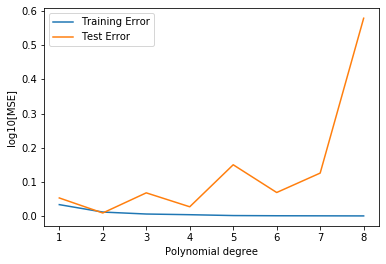

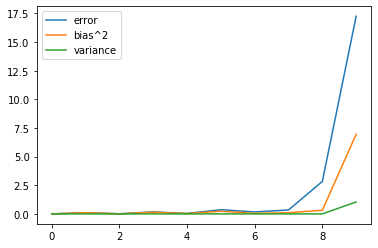

In [198]:
maxdegree = 10

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)

polynomial = np.zeros(maxdegree)


for polydegree in range(1, maxdegree):
    polynomial[polydegree] = polydegree
    for degree in range(polydegree):
        DM = CreateDesignMatrix_X(x_1, y_1, n=degree)
    
    error[polydegree] = 0.0
    bias[polydegree] = 0.0
    variance[degree] = 0.0
    
    for samples in range(trials):
        DM_train, DM_test, z_1_train, z_1_test, ztrue_train, ztrue_test = train_test_split(DM, z_1, z_true, test_size=0.2, shuffle=False)
        model = skl.LinearRegression(fit_intercept=True).fit(DM_train, z_1_train)
        
        ztilde = model.predict(DM_train)
        zpred = model.predict(DM_test)
        
        error[polydegree] += np.mean(np.mean((ztrue_test - zpred)**2))
        bias[polydegree] += np.mean((ztrue_test - np.mean(zpred))**2)
        variance[polydegree] = np.mean(np.var(zpred))

    error[polydegree] /= trials
    bias[polydegree] /= trials
    variance[polydegree] /= trials


plt.plot(polynomial, error, label='error')
plt.plot(polynomial, bias, label='bias^2')
plt.plot(polynomial, variance, label='variance')
plt.legend()
plt.show()

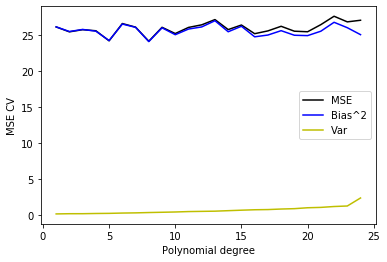

In [67]:
degrees = np.arange(1,25)

k = 5
kfold = KFold(n_splits = k, shuffle=True)

array_size_thingy=len(z_test)

z_1 = z_1.reshape(-1,1)

error = []
bias = []
variance = []
for deg in degrees:
    z_pred = np.empty((array_size_thingy, k))
    
    j=0
    X2 = CreateDesignMatrix_X(x_1, y_1, n=deg)
    model = skl.LinearRegression(fit_intercept=False)

    for train_inds, test_inds in kfold.split(z_1):
        xtrain = X2[train_inds]
        ztrain= z_1[train_inds]
        xtest = X2[test_inds]
        ztest = z_1[test_inds]
        z_pred[:,j] = model.fit(xtrain, ztrain).predict(xtest).ravel()
        
        j+=1

    err = np.mean(np.mean((ztest - z_pred)**2))
    bi = np.mean((ztest - np.mean(z_pred))**2)
    var = np.mean(np.var(z_pred))
    error.append(err)
    bias.append(bi)
    variance.append(var)

max_pd = 25 #max polynomial degree to plot to

plt.figure()
plt.plot(degrees[:max_pd],error[:max_pd],'k',label='MSE')
plt.plot(degrees[:max_pd],bias[:max_pd],'b',label='Bias^2')
plt.plot(degrees[:max_pd],variance[:max_pd],'y',label='Var')
summ=np.zeros(len(variance))
for i in range(len(error)):
    summ[i]=variance[i]+bias[i]
#plt.plot(degrees[:max_pd],summ[:max_pd],'ro',label='sum')

plt.xlabel('Polynomial degree')
plt.ylabel('MSE CV')
plt.legend()
plt.show()

# Part D) Ridge Regression on the Franke function with resampling

First remove the first column (the intercept) so that this one is not penalised by lambda (???) You don't need to remove the intercept column for this project. Normally, if you remove the intercept column you also have to take the mean blabla something

In [24]:
_lambda = 10**-2

In [25]:
betaridge = np.linalg.inv(X_train.T.dot(X_train)+(_lambda*np.eye(len(X_train[0])))).dot(X_train.T).dot(z_train)
zridge = X_train @ betaridge

ridge_predict = X_test @ betaridge

In [26]:
print("var(beta) OLS:", np.var(beta))
print("var(beta) ridge:", np.var(betaridge))

var(beta) OLS: 386.37780040219076
var(beta) ridge: 27.64757912446408


In [27]:
print("MSE OLS:", MSE(z_true_test, zpredict))
print("MSE ridge:", MSE(z_true_test, ridge_predict))

MSE OLS: 0.003414051081738338
MSE ridge: 0.004838755355778765


In [28]:
print("R2 OLS:", R2(z_true_test, zpredict))
print("R2 Ridge:", R2(z_true_test, ridge_predict))

R2 OLS: 0.9600565864670063
R2 Ridge: 0.9433911358813973


The ridge regression for different lambdas, to find out which lambda is best

In [29]:
nlambdas = 500
lambdas = np.logspace(-7, 5, nlambdas)

k = 10
kfold = KFold(n_splits = k, shuffle=True)

mse_scores_KFold = np.zeros((nlambdas, k))
r2_scores_KFold = np.zeros((nlambdas, k))

i = 0
for lmb in lambdas:
    betaridge1 = np.linalg.inv(X_train.T.dot(X_train)+(lmb*np.eye(len(X_train[0])))).dot(X_train.T).dot(z_train)
    j = 0
    for train_inds, test_inds in kfold.split(x):
        Xtrain_r = X[train_inds]
        ztrain_r = z_1[train_inds]

        Xtest_r = X[test_inds]
        ztest_r = z_true[test_inds]
        
        zpred_r = Xtest_r @ betaridge1

        mse_scores_KFold[i,j] = np.sum((zpred_r - ztest_r)**2)/np.size(zpred_r)
        #r2_scores_KFold[i,j] = 1 - np.sum((ztest_r - zpred_r) ** 2) / np.sum((ztest_r - np.mean(zpred_r)) ** 2)

        j += 1
    i += 1

estimated_mse_KFold = np.mean(mse_scores_KFold, axis = 1)
#estimated_r2_KFold = np.mean(r2_scores_KFold, axis = 1)

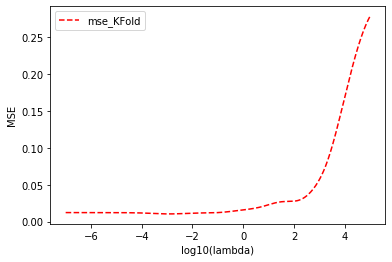

In [30]:
plt.figure()

plt.plot(np.log10(lambdas), estimated_mse_KFold, 'r--', label = 'mse_KFold')

plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

The same with sklearn and GridSearchCV. 
sklearn automatically splits the data (because of the CV) so put in the whole dataset here, and not the train data! it tests on the noisy data though, that's where the difference comes from. The negative MSE means that it is just the other side of the MSE so you can 'ignore' the minus sign

In [31]:
param_grid = {'alpha': lambdas}

ridge = Ridge()

ridge_regressor = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=kfold)
ridge_regressor.fit(X, z_1)

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 0.0014465073385216472}
-1.024432343828672


In [32]:
nlambdas = 500
lambdas = np.logspace(-7, 5, nlambdas)

k = 10
kfold = KFold(n_splits = k, shuffle=True)

estimated_mse_sklearn = np.zeros(nlambdas)

i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)

    estimated_mse_folds = cross_val_score(ridge, X, z_1, scoring='neg_mean_squared_error', cv=kfold)
    estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)
    i += 1

print(np.mean(estimated_mse_sklearn))

1.0352687273571615


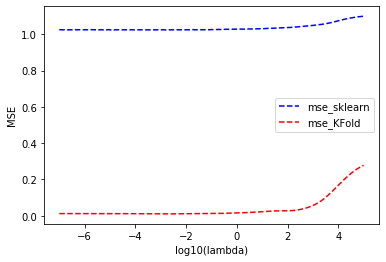

In [33]:
plt.figure()

plt.plot(np.log10(lambdas), estimated_mse_sklearn, 'b--', label = 'mse_sklearn')
plt.plot(np.log10(lambdas), estimated_mse_KFold, 'r--', label = 'mse_KFold')

plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Part E) Lasso Regression on the Franke function with resampling


Start by finding the optimal value for lambda for lasso, using GridSearchCV

In [34]:
nlambdas = 500
lambdas_lasso = np.logspace(-4, 10, nlambdas)
param_grid_lasso = {'alpha': lambdas_lasso}

lasso = Lasso(precompute = True, tol = 0.001)

lasso_regressor = GridSearchCV(lasso, param_grid_lasso, scoring='neg_mean_squared_error', cv=10)
lasso_regressor.fit(X, z_1)

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172.96647371305698, tolerance: 9.85051643705757
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 232.96702714757066, tolerance: 9.803966370156354
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149.6266920490416, tolerance: 9.834626629494586
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116.86054447248807, tolerance: 9.967627415850137
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.4079059567357, tolerance: 9.909900497268735
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.75056928048616, tolerance: 9.85051643705757
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.902585588199145, tolerance: 9.940118953557933
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.46439231059776, tolerance: 9.967627415850137
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.174185237869096, tolerance: 9.834626629494586
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.696237475998714, tolerance: 10.069048083383768
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.156081578441444, tolerance: 10.074087102130827
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.018578665309178, tolerance: 9.940118953557933
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Con

{'alpha': 0.0002635370519267393}
-1.0310593718060275


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.980318283529414, tolerance: 11.036210229998028
  tol, rng, random, positive)


The optimal value for lambda is around 3.2^-4. If we use this value for lambda we can compare the MSE and R2 scores for all three models

In [35]:
l_lambda = 0.00032

clf_lasso = skl.Lasso(alpha=l_lambda, precompute = True, tol = 0.01).fit(X_train, z_train)
pred_lasso = clf_lasso.predict(X_test)

In [36]:
print("MSE OLS:", MSE(z_true_test, zpredict))
print("MSE ridge:", MSE(z_true_test, ridge_predict))
print("MSE lasso:", MSE(z_true_test, pred_lasso))

MSE OLS: 0.003414051081738338
MSE ridge: 0.004838755355778765
MSE lasso: 0.011688937735854601


In [37]:
print("R2 OLS:", R2(z_true_test, zpredict))
print("R2 Ridge:", R2(z_true_test, ridge_predict))
print("R2 lasso:", R2(z_true_test, pred_lasso))

R2 OLS: 0.9600565864670063
R2 Ridge: 0.9433911358813973
R2 lasso: 0.8632105930172186
